# IMERG
<!-- markdownlint-disable MD013 -->

In [38]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import pandas as pd
import ocha_stratus as stratus

from src.datasources import imerg, ibtracs, zma
from src.constants import *

## Load IMERG

In [40]:
pcode = "CU"

In [41]:
%%time
# load all IMERG data - bit slow
df_imerg = imerg.load_imerg(pcode)

CPU times: user 99.9 ms, sys: 185 ms, total: 285 ms
Wall time: 31.6 s


In [42]:
df_imerg["valid_date"] = pd.to_datetime(df_imerg["valid_date"])

<Axes: >

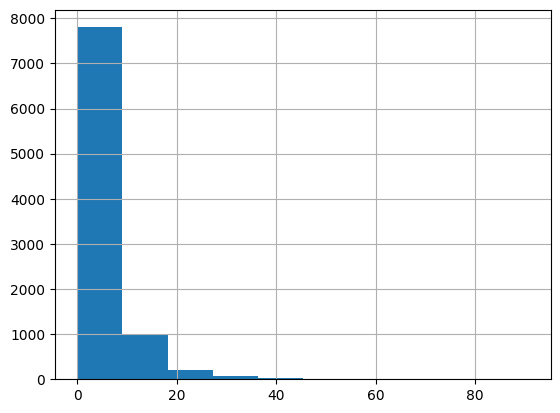

In [43]:
df_imerg["mean"].hist()

In [44]:
df_imerg["roll2_mean"] = df_imerg["mean"].rolling(2).sum()

Just get a general idea of yearly peak values

In [45]:
df_imerg.groupby(df_imerg["valid_date"].dt.year)[
    "roll2_mean"
].max().reset_index().sort_values("roll2_mean", ascending=False)

,valid_date,roll2_mean
10,2010,125.514080
1,2001,120.507424
8,2008,114.313233
20,2020,112.243160
2,2002,111.557137
18,2018,108.781929
23,2023,99.384370
5,2005,97.973385
11,2011,97.300541
7,2007,95.026070


In [46]:
df_imerg

,iso3,pcode,valid_date,adm_level,mean,median,min,max,count,sum,std,roll2_mean
0,CUB,CU,2000-06-04,0,6.914716,3.870000,0.0,59.784996,3791,26213.690,7.977752,NaN
1,CUB,CU,2000-06-05,0,10.971368,6.254999,0.0,95.700000,3791,41592.453,12.472013,17.886084
2,CUB,CU,2000-06-06,0,6.899565,4.270000,0.0,39.845000,3791,26156.250,7.358684,17.870933
3,CUB,CU,2000-06-07,0,2.988547,0.915000,0.0,38.565000,3791,11329.580,4.963941,9.888111
4,CUB,CU,2000-06-08,0,4.753370,3.015000,0.0,34.489998,3791,18020.025,5.450318,7.741917
...,...,...,...,...,...,...,...,...,...,...,...,...
9105,CUB,CU,2025-04-30,0,0.338537,0.000000,0.0,11.254999,3791,1283.395,1.224375,1.829400
9106,CUB,CU,2025-05-01,0,0.573351,0.000000,0.0,34.510000,3791,2173.575,2.060242,0.911889
9107,CUB,CU,2025-05-03,0,7.477400,2.075000,0.0,107.269990,3791,28346.824,12.027663,8.050752
9108,CUB,CU,2025-05-06,0,3.942065,0.605000,0.0,78.469986,3791,14944.369,8.655358,11.419465


## Process rainfall
### Load storms

In [47]:
gdf_zma = zma.load_zma()

In [48]:
df_all = ibtracs.load_ibtracs_in_bounds(*gdf_zma.total_bounds)

In [50]:
df_agg = (
    df_all.groupby("sid")
    .agg(
        valid_time_min=("valid_time", "min"),
        valid_time_max=("valid_time", "max"),
        wind_speed_max=("wind_speed", "max"),
    )
    .reset_index()
)

### Get rainfall per storm 

Relatively simplistic - look at the dates the storm was in the ZMI, and take the 2-day rolling sum of rainfall over the whole country (this is what is used as a trigger in Haiti, so could be a good starting point). We include one day on either side of the time the storm is in the ZMI.

In [51]:
def get_storm_rainfall(storm_row):
    min_date = storm_row["valid_time_min"].date()
    max_date = storm_row["valid_time_max"].date() + pd.DateOffset(days=1)
    dff_imerg = df_imerg[
        (df_imerg["valid_date"] >= pd.Timestamp(min_date))
        & (df_imerg["valid_date"] <= pd.Timestamp(max_date))
    ]
    storm_row["max_roll2_mean"] = dff_imerg["roll2_mean"].max()
    return storm_row

In [52]:
df_agg = df_agg.apply(get_storm_rainfall, axis=1)

In [53]:
df_agg

,sid,valid_time_min,valid_time_max,wind_speed_max,max_roll2_mean
0,1851228N13313,1851-08-19 12:00:00.000040,1851-08-21 12:00:00.000040,70.0,NaN
1,1852232N21293,1852-08-20 12:00:00.000040,1852-08-22 12:00:00.000040,90.0,NaN
2,1852249N17296,1852-09-06 18:00:00.000040,1852-09-06 18:00:00.000040,40.0,NaN
3,1852264N13309,1852-09-27 00:00:00.000040,1852-09-28 00:00:00.000040,80.0,NaN
4,1852278N14293,1852-10-07 12:00:00.000040,1852-10-08 06:00:00.000040,90.0,NaN
...,...,...,...,...,...
468,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0,43.101876
469,2024268N17278,2024-09-24 06:00:00.000039,2024-09-26 06:00:00.000039,75.0,51.583454
470,2024279N21265,2024-10-09 02:05:00.000035,2024-10-09 06:00:00.000039,140.0,4.291707
471,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 12:00:00.000039,75.0,26.294549


In [54]:
blob_name = f"{PROJECT_PREFIX}/processed/storm_stats/zma_stats.parquet"

In [55]:
stratus.upload_parquet_to_blob(df_agg, blob_name)